<a href="https://colab.research.google.com/github/tacla/Sistemas-Inteligentes/blob/main/CART/Regressor_Valid_Cruzada_CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## REGRESSOR & VALIDAÇÃO CRUZADA
**Objetivo**: Explorar um algoritmo de aprendizado de máquina, CART, para compreender o método de validação cruzada e as métricas utilizadas para avaliar um modelo de regressor.

**CART**: Classification and Regression Trees é um algoritmo de aprendizado de máquina que aprende uma árvore de decisão de forma indutiva. Pode ser usado tanto para aprender um classificador como um regressor.

**Glossário utilizado no nosso curso**
* **treino**: dataset de treinamento
* **validação**: parte do dateset de treinamento utilizado para validar
* **teste cego**: dados que não foram utilizados na etapa de treinamento/validação



Frequentemente, as bibliotecas utilizam *treino/teste* em vez de *treino/validação*.

**(1) Geração de um dataset artificial**

Gerar pontos que seguem uma senoidal com ruído. Neste exemplo, nós conhecemos a função verdadeira e vamos acrescentar ruido. Em seguida vamos ver o quanto o regressor se aproxima da função verdadeira.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gerar uma senoide
np.random.seed(42)  # For reproducibility
N_SAMPLES = 1200    # Number of samples
NOISE = 0.1         # ruido

# X vem de uma distribuição uniforme
X = np.random.uniform(0, 1, N_SAMPLES)

# Função verdadeira = sin(2.pi.x)
def true_fun(X):
    return np.sin(2 * np.pi * X)

# Ruido: normal(mean, std_dev, samples)
noise = np.random.normal(0, NOISE, N_SAMPLES).reshape(-1, 1)

# Valores de y sem ruido
y = true_fun(X)

y_noisy = y + noise.flatten()



**(2) Plotar a função verdadeira**

Vamos ver a função verdadeira e os pontos com ruído.É a partir destes pontos que CART vai fazer uma aproximação da curva verdadeira.

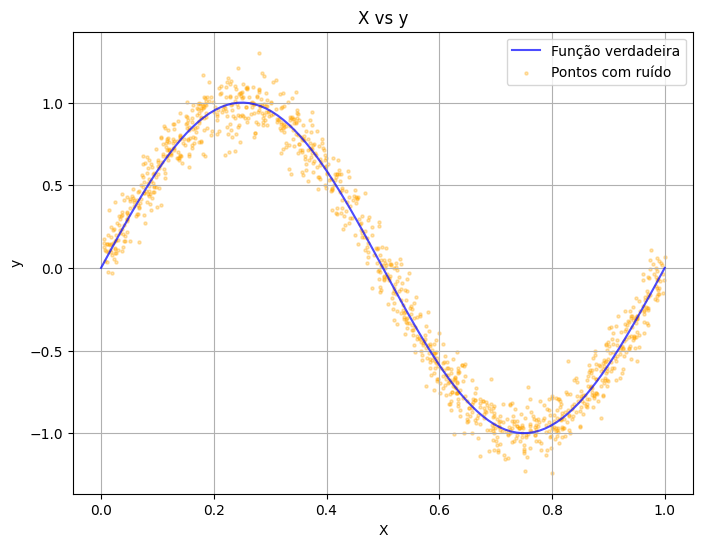

In [2]:
plt.figure(figsize=(8, 6))
X_plot = np.linspace(0, 1, 100)
plt.plot(X_plot, true_fun(X_plot), label='Função verdadeira', color='blue', alpha=0.7)

# s define o tamanho do ponto
plt.scatter(X, y_noisy, s=5, label='Pontos com ruído', color='orange', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.title('X vs y')
plt.legend()
plt.grid(True)
plt.show()


**(3) Validação cruzada**

É um método para treinar/validar e testar modelos de aprendizado para evitar a sobreadaptação (*overfitting*) às amostras de treinamento.

SciKit possibilita fracionar o dataset para evitar este problema. Vamos dividir o dataset em duas partes:
1.   para treinamento e validação (vou chamar train)
2.   para testes com dados não utilizados em 1 (vou chamar de test)


**Parêmetros importantes**:
* *test_size*: qual fração do dataset será reservado para testes (entre 20-30%)
* *shuffle*: boolean; embaralha ou não antes de dividir (recomendável true)

Você pode fazer o fracionamento do dataset manualmente com a função *train_test_split*.

Documentação: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

In [3]:
from sklearn.model_selection import train_test_split
## Dividir o dataset em treinamento/validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=0.3, shuffle=True)

#\t{value}>4 tabulação a direita (reserva 4 algarismos)
print(f"Tam. total do dataset.......:\t{len(X):>4}")
print(f"Tam. dataset treino & valid.:\t{len(X_train):>4}")
print(f"Tam. dataset testes cegos...:\t{len(X_test):>4}")

Tam. total do dataset.......:	1200
Tam. dataset treino & valid.:	 840
Tam. dataset testes cegos...:	 360


**(4) Parametrizações de treinamento**

Vamos experimentar [2 parametrizações diferentes](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

* ***max_depth***: profundidade máxima da árvore: `[4, 16]`
* ***min_samples_leaf***:  número mínimo de amostras por folha: `[0.25, 0.01]` - quando utilizamos float, significa um percentual das amostras reservadas para treinamento.

```
Para cada parametrização:
- para cada um dos k folds:
  - cross_val_score treina um modelo
  - cross_val_score calcula o erro para os dados de treinamento e validação separadamente
- temos k modelos diferentes
```

A ideia é mostrar as diferenças entre duas parametrizações:

1) **underfitted**: profundidade máx.=2, min_samples_leaf=0.25

2) **overfitted**: profunidade máx.=16, min_samples_leaf=0.01

---



In [4]:
from sklearn.tree import DecisionTreeRegressor

## Metricas para regressao
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate

# Parametros
k_folds = 5
num_params = 2          # num de parametrizacoes a treinar
max_depth=[2, 16]
min_samples_leaf=[0.25, 0.01]

# Vars para salvar os modelos e resultados
best_model=[]   # armazenar o melhor modelo da 1a. e da 2a. parametrização
model=[]        # todos os modelos de cada parametrização
train_scores=[]
vld_scores=[]
best_index=[]
mse=[]

# Instanciação do regressor i
for i in range(num_params):
  dt = DecisionTreeRegressor(max_depth=max_depth[i], min_samples_leaf=min_samples_leaf[i], random_state=42)

  # cross_validate faz fit e retorna para cada fold o modelo aprendido,
  # o score de treino e o de validação (ver mais abaixo)
  cv_results = cross_validate(
      dt,
      X_train.reshape(-1, 1),
      y_train,
      cv=k_folds,
      scoring='neg_mean_squared_error', # scikit usa negativo para manter o padrao de quanto mais alto o score, melhor o estimador
                                        # Neste caso, quanto maior o MSE (negativo), melhor será porque mede o erro.
      return_train_score=True,  # Include training scores
      return_estimator=True    # Include trained models
  )

  # MSE de treino e validação
  train_scores.append(cv_results['train_score'])
  vld_scores.append(cv_results['test_score'])

  # Diferença absluta do MSE do treinamento e de validação
  bias = np.abs(train_scores[i] - vld_scores[i])

  # Salva o indice do menor 'vies' (diferença entre train e validação)
  best_index.append(np.argmin(bias))

  # Salva o modelo que apreenta a menor diferença entre score de treinamento e validação (diferença abs)
  best_model.append(cv_results['estimator'][best_index[i]])

  # Salva todos os modelos da parametrizacao
  model.append(cv_results['estimator'])

  print(f"Parametrization {i+1}: {model}")
  print(f"Best Index: {best_index[i]}\n")


Parametrization 1: [[DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42)]]
Best Index: 2

Parametrization 2: [[DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42), DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.25, random_state=42)], [DecisionTreeRegressor(max_depth=16, min_samples_leaf=0.01, random_state=42), DecisionTreeRegressor(max_depth=16, min_samples_leaf=0.01, random_state=42), DecisionTreeRegressor(max_


----

**(5) Visualização dos resultados de treinamento e validação**

Vamos comparar o resultado das duas parametrizações para cada modelo aprendido (1 por fold).

Observe as diferenças dos MSEs de treino e de validação.
A parametrização 1 é pior do que a 2.

Viés aqui é calculado de modo aproximado para cada fold:

`abs(NEG_MSE_train - NEG_MSE_vld)`

e para a média dos MSEs (coluna Mean).


Observe que usamos o **NEG MSE** (MSE negativo). Scikit-learn faz isso para manter a coerência na avaliação de estimadores por um score qualquer: quanto maior o score, melhor o modelo. Como o MSE representa o erro de aprendizado, quanto maior, pior é! Por isso ele inverte os sinal.


In [5]:
  # Resultados
  print("Train & Valid Scores (Neg MSE) per parametrization:")
  for i in range(num_params):
    print(f"Par{i+1}\tMean\t\tScores per fold")
    print(f"Trn:\t{train_scores[i].mean():>8.5f}\t{train_scores[i]}")
    print(f"Vld:\t{vld_scores[i].mean():>8.5f}\t{vld_scores[i]}")
    print(f"Vies:\t{np.abs(train_scores[i].mean() - vld_scores[i].mean()):>8.5f}\t{abs(train_scores[i] - vld_scores[i])}")
    print(f"Best index: {best_index[i]}")
    print()

Train & Valid Scores (Neg MSE) per parametrization:
Par1	Mean		Scores per fold
Trn:	-0.09674	[-0.09350576 -0.09973016 -0.09722743 -0.09544607 -0.09778906]
Vld:	-0.09930	[-0.11592974 -0.08511661 -0.09526033 -0.1057349  -0.09446846]
Vies:	 0.00256	[0.02242399 0.01461355 0.0019671  0.01028882 0.0033206 ]
Best index: 2

Par2	Mean		Scores per fold
Trn:	-0.00763	[-0.0076339  -0.00737636 -0.00773702 -0.00785571 -0.0075579 ]
Vld:	-0.01234	[-0.01184864 -0.01287386 -0.01253443 -0.01126331 -0.01316557]
Vies:	 0.00470	[0.00421474 0.0054975  0.00479741 0.00340759 0.00560767]
Best index: 3



Vamos comparar graficamente os resultados das duas parametrizações. Recordar que estamos utilizando o MSE negativo como score, então quanto maior melhor. No print acima, observe os melhores índices:
* **parametrização 1 (azul)**: índice 3, veja **fold=4** e a proximidade dos valores de MSE para os dados de treinamento e de validação nas curvas inferiores. Observe também as retas que representam o valor médio do MSE para treinamento e validação.
* **parametrização 2 (laranja)**: índice 0, idem para **fold=1**, nas curvas superiores.

Interessante que a **parametrização 1** é subajustada, mas apresenta um equilíbrio melhor entre viés e variância do que a parametrização 2. As linhas retas que representam o MSE médio estão mais próximas do que as da parametrização 2.

A **parametrização 2** está sobreajustada. Deste modo, a variância é muito grande. Pontos vizinhos podem ter predições bem diferentes.

Também observar que os *scores* são aproximações do viés e da variância. O cálculo estatístico é um pouco diferente.


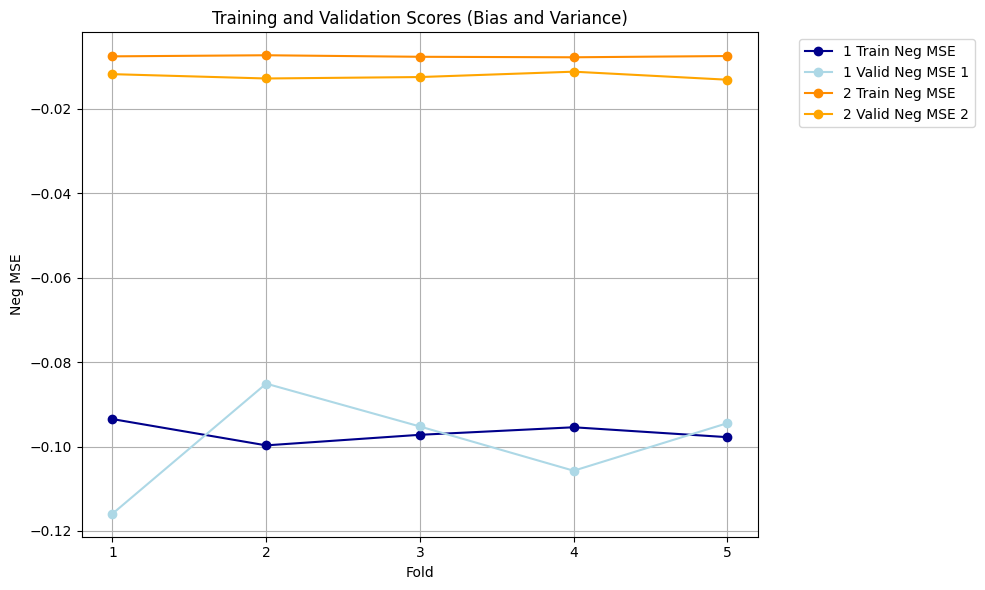

In [9]:
plt.figure(figsize=(10, 6))
colors = [
    ["darkblue", "lightblue"],  # Tons de azul para i=0
    ["darkorange", "orange"],  # Tons de laranja para i=1
    ["darkgreen", "lightgreen"],  # Tons de verde para i=2 (se houver mais índices)
]

for i in range(num_params):
    plt.plot(range(1, len(train_scores[i]) + 1), train_scores[i], label=f"{i+1} Train Neg MSE", marker='o', color=colors[i][0])
    plt.plot(range(1, len(vld_scores[i]) + 1), vld_scores[i], label=f"{i+1} Valid Neg MSE {i+1}", marker='o', color=colors[i][1])
    #plt.axhline(train_scores[i].mean(), color=colors[i][0], linestyle='--', label=f"{i+1} Train.mean {i+1}: {train_scores[i].mean():.2f}")
    #plt.axhline(vld_scores[i].mean(), color=colors[i][1], linestyle='--', label=f"{i+1} Valid.mean {i+1}: {vld_scores[i].mean():.2f}")

# Add labels and legend
plt.xlabel("Fold")
plt.ylabel("Neg MSE")
plt.title("Training and Validation Scores (Bias and Variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Posição da legenda fora do gráfico
plt.xticks(np.arange(1, k_folds + 1, 1))
plt.grid()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()



## ÁRVORE DE DECISÃO: MELHOR MODELO APRENDIDO

Agora vamos visualizar as árvores de cada uma das parametrizações.

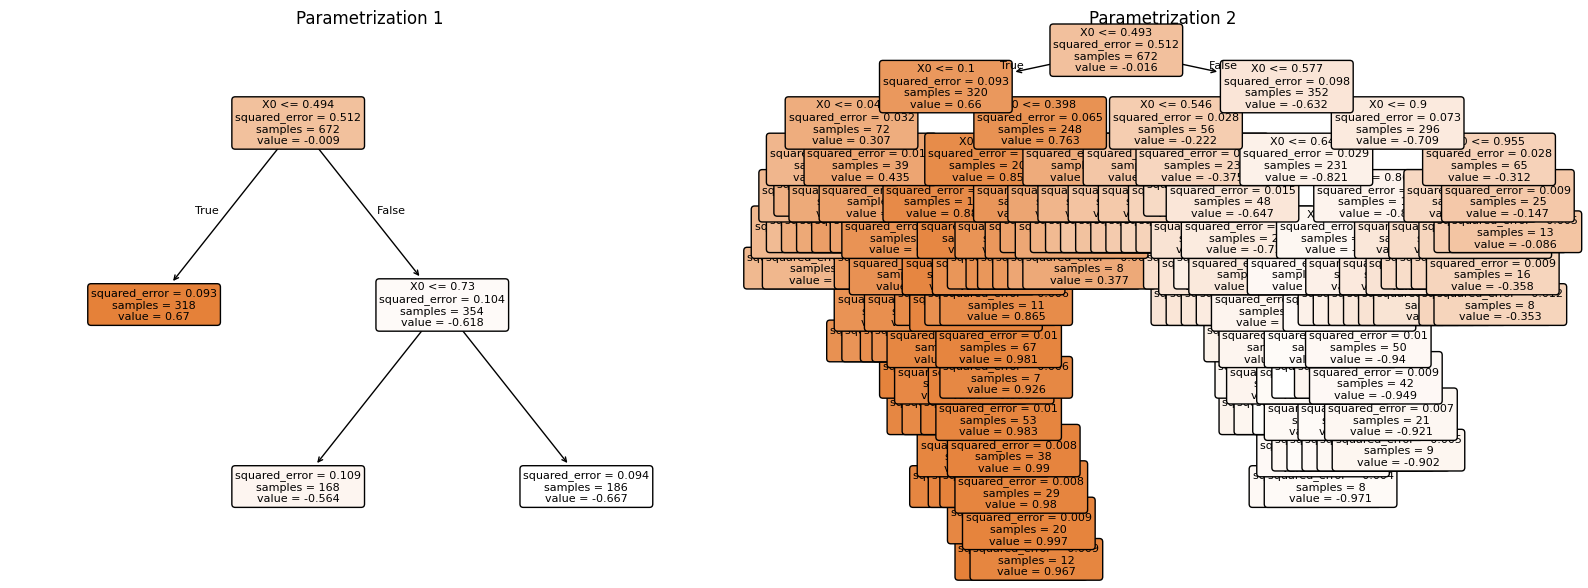

In [7]:
from sklearn import tree
fig, axes = plt.subplots(1, num_params, figsize=(16, 6))  # 1 row, num_params columns

for i in range(num_params):
    tree.plot_tree(best_model[i],
                   feature_names=["X0"],
                   filled=True,
                   rounded=True,
                   class_names=True,
                   fontsize=8,
                   ax=axes[i])  # Assign the plot to the correct subplot
    axes[i].set_title(f"Parametrization {i+1}")  # Add a title to each subplot

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


---

**Visualizar os modelos aprendidos**

Agora, vamos rodar o melhor modelo da parametrização 1 (curva azul) e o melhor da 2 (curva laranja). As diferentes curvas representam os modelos aprendidos para x0=[0, 1]. Observar como se aproximam da função verdadeira f(x).

Fica bem claro que a parametrização 1 é subajustada (precisão baixa) enquanto a 2 está sobreajustada (bastante sujeita a variações para pontos próximos).

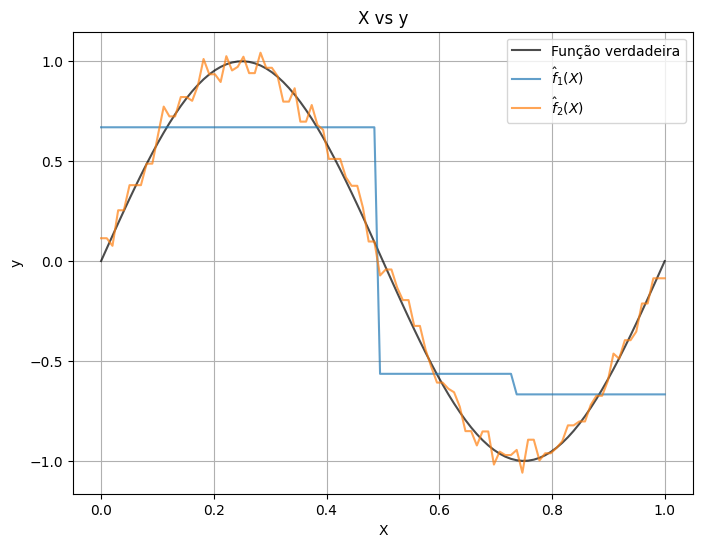

In [8]:
from matplotlib import cm
plt.figure(figsize=(8, 6))
plt.plot(X_plot, true_fun(X_plot), label='Função verdadeira', color='black', alpha=0.7)

for i in range(num_params):
  color = cm.viridis(i / (num_params - 1))
  plt.plot(X_plot, best_model[i].predict(X_plot.reshape(-1, 1)),
           label=r'$\hat{f}_{' + str(i+1) + '}(X)$', alpha=0.7)

plt.xlabel('X')
plt.ylabel('y')
plt.title('X vs y')
plt.legend()
plt.grid(True)
plt.show()